# Solution to programming exercises week 4

INF2310, spring 2017

## Task 2

In this task, we will implement our own histogram function.

In [62]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [63]:
def get_histogram(image, low=0, high=255, num_bins=255, normalized=False):
    """Simple histogram function.
    
    This function counts the number of values in each bin. The bins are
    uniform in size, and are
    
        [low, low+bin_size), [low+bin_size), ..., [high-bin_size, high]
    
    where
    
        bin_size = (high - low) / num_bins.

    Args:
        image: n-dimensional numpy array
        low: int. Smallest value included in bins
        high: int. Largest value included in bins
        bin_size: int. Size of bin.
        normalized: bool. We assume uniform bin size, therefore if normalized == True,
                    sum(hist)*bin_size = 1. Otherwise hist is just the intensity frequency
                    in the image.

    Returns:
        bins: 1D numpy array. Bin values used in the histogram.
        hist: 1D numpy array. Histogram values.
    """

    bins = np.linspace(low, high, num_bins+1)
    hist = np.zeros(num_bins, dtype='int64')
    
    # Feel free to try different versions
    for k in range(num_bins):
        hist[k] = np.sum(((image >= bins[k])*(image < bins[k+1]))*1)
        if k == num_bins-1:
            hist[k] = np.sum(((image >= bins[k])*(image <= bins[k+1]))*1)

    if normalized:
        # We assume uniform bin size
        bin_size = bins[1] - bins[0]
        # Normalized now means that the sum of elements in the unnormalized
        # histogram times the bin size should equal 1, therefore
        hist = hist / (np.sum(hist) * bin_size)
            
    # Check with numpy version
    np_hist, np_bins = np.histogram(image.flatten(), bins=num_bins, range=[low, high], density=normalized)

    for k, _ in enumerate(hist):
        # Float comparison
        assert np.isclose(hist[k], np_hist[k]), 'Something wrong in index ' + str(k)

    return bins, hist

### Tests

In [64]:
test_im = np.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]])
bins, hist = get_histogram(test_im, 0, 10, 10, False)
print(test_im)
print(bins)
print(hist)

[[1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
[0 1 2 3 3 2 1 0 0 0]


Image mean:  124.108253479
Image standard deviation:  47.9368693516


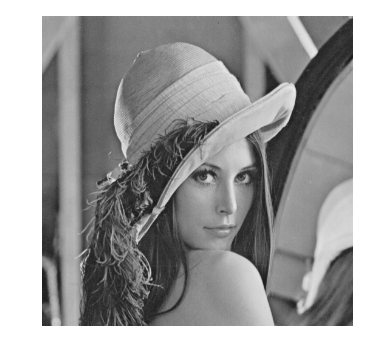

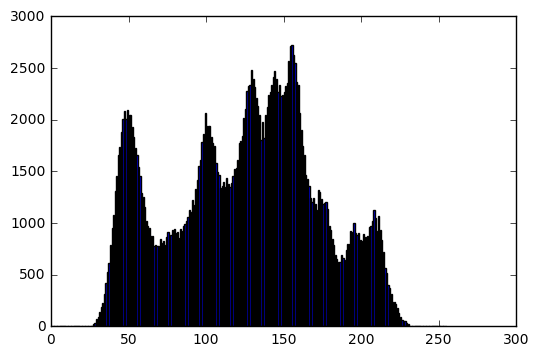

In [65]:
im = cv2.imread('../../assets/images/lena.png', cv2.IMREAD_GRAYSCALE)

bins, hist = get_histogram(im)

plt.figure(0)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Image mean: ', np.mean(im))
print('Image standard deviation: ', np.std(im))

## Task 4

In this task, we shall apply a linear grayscale transform on an image such that the result image has a given mean value and standard deviation.

First, let us import an image, and display it

Image info:
Data type:  uint8
Min intensity value:  27
Max intensity value:  246
Mean:  133.389663696
Standard deviation:  45.4581301793


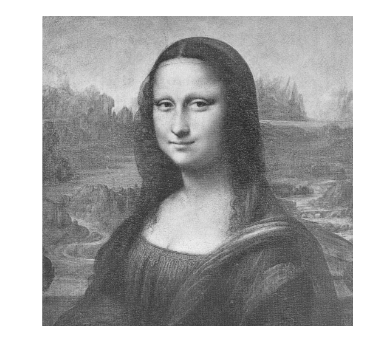

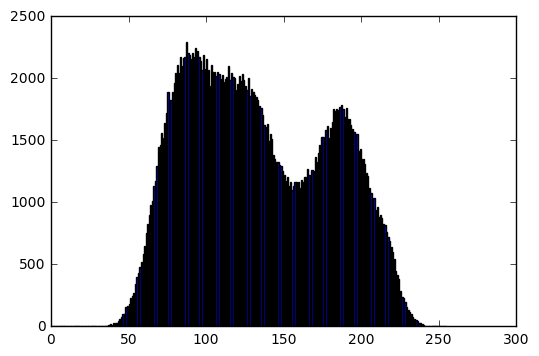

In [66]:
im = cv2.imread('../../assets/images/mona.png', cv2.IMREAD_GRAYSCALE)

bins, hist = get_histogram(im)

plt.figure(0)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Image info:')
print('Data type: ', im.dtype)
print('Min intensity value: ', im.min())
print('Max intensity value: ', im.max())
print('Mean: ', np.mean(im))
print('Standard deviation: ', np.std(im))

Then, we perform a linear transform

Transformed image info:
Data type:  float64
Min intensity value:  53.1922394183
Max intensity value:  149.544640688
Mean:  100.0
Standard deviation:  20.0


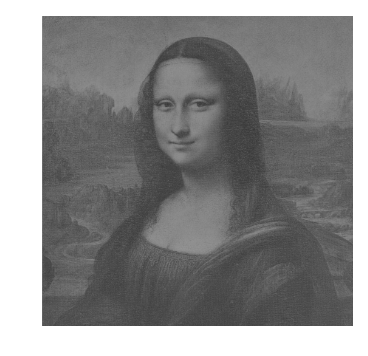

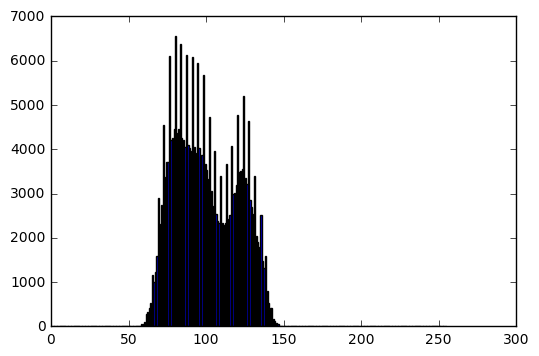

In [67]:
target_mean = 100
target_stddev = 20

input_mean = np.mean(im)
input_stddev = np.std(im)

scale = target_stddev / input_stddev   # "a" in the lecture slides
shift = target_mean - scale*input_mean # "b" in the lecture slides

# Perform the transformation
transformed_im = shift + scale*im

# Cut the image values < 0 and > 255
transformed_im = transformed_im - transformed_im*(transformed_im < 0) - transformed_im*(transformed_im > 255)

bins, hist = get_histogram(transformed_im)

# Display result
plt.figure(0)
plt.imshow(transformed_im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Transformed image info:')
print('Data type: ', transformed_im.dtype)
print('Min intensity value: ', transformed_im.min())
print('Max intensity value: ', transformed_im.max())
print('Mean: ', np.mean(transformed_im))
print('Standard deviation: ', np.std(transformed_im))

### Extra: A more general tranform function

Below, there is implementations of a linear transform, a logarithmic transform and a power transform.

In [68]:
def transform(image, which_transform, scale=1, shift=0, power=1):
    """Transforms the input image.
        
    Args:
        image: n-dimensional numpy array with values in [0, 255].
        which_transform: str in {'linear', 'log', 'power'}
        scale: Scaling parameter used if which_transform == 'linear'
        shift: Shift parameter used if which_transform == 'linear'
        power: What power to use if which_transform == 'power'.
        
    Returns:
        tr_image: numpy array with same shape as image.
    """
    
    if which_transform == 'linear':
        tr_image = shift + scale*im
        # Cut values < 0 and > 255
        tr_image = tr_image - tr_image*(tr_image < 0) - tr_image*(tr_image > 255)
    elif which_transform == 'log':
        # This is such that intensity value 0 is mapped to 0, and intensity value
        # 255 is mapped to 255.
        c = 255 / np.log(256)
        tr_image = c * np.log(image.astype(np.float) + 1)
    elif which_transform == 'power':
        # This is such that intensity value 0 is mapped to 0, and intensity value
        # 255 is mapped to 255.
        c = 255 / (255**power)
        tr_image = c * (im.astype(np.float)**power)
    else:
        print('Transform {} is not implemented yet'.forma(which_transform))
        tr_image = np.zeros_like(image)
        
    return np.round(tr_image).astype('uint8')

#### Linear transform

Transformed image info:
Data type:  uint8
Min intensity value:  53
Max intensity value:  150
Mean:  100.010593414
Standard deviation:  20.0034103902


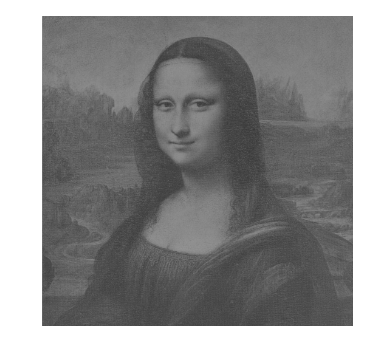

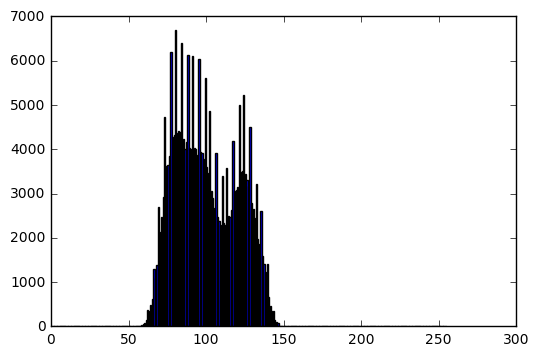

In [69]:
target_mean = 100
target_stddev = 20

input_mean = np.mean(im)
input_stddev = np.std(im)

scale = target_stddev / input_stddev   # "a" in the lecture slides
shift = target_mean - scale*input_mean # "b" in the lecture slides

transformed_im = transform(im, which_transform='linear', scale=scale, shift=shift)

bins, hist = get_histogram(transformed_im)

# Display result
plt.figure(0)
plt.imshow(transformed_im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Transformed image info:')
print('Data type: ', transformed_im.dtype)
print('Min intensity value: ', transformed_im.min())
print('Max intensity value: ', transformed_im.max())
print('Mean: ', np.mean(transformed_im))
print('Standard deviation: ', np.std(transformed_im))

#### Logarithmic transform

Transformed image info:
Data type:  uint8
Min intensity value:  153
Max intensity value:  253
Mean:  222.567173004
Standard deviation:  16.4205089579


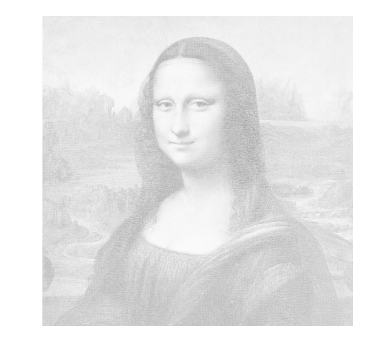

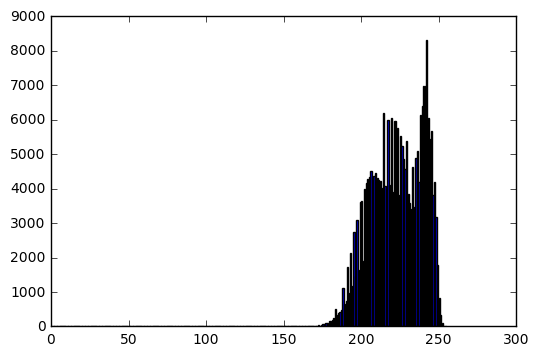

In [70]:


transformed_im = transform(im, which_transform='log')

bins, hist = get_histogram(transformed_im)

# Display result
plt.figure(0)
plt.imshow(transformed_im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Transformed image info:')
print('Data type: ', transformed_im.dtype)
print('Min intensity value: ', transformed_im.min())
print('Max intensity value: ', transformed_im.max())
print('Mean: ', np.mean(transformed_im))
print('Standard deviation: ', np.std(transformed_im))

#### Power transform

Transformed image info:
Data type:  uint8
Min intensity value:  3
Max intensity value:  237
Mean:  77.8498153687
Standard deviation:  49.9954186908


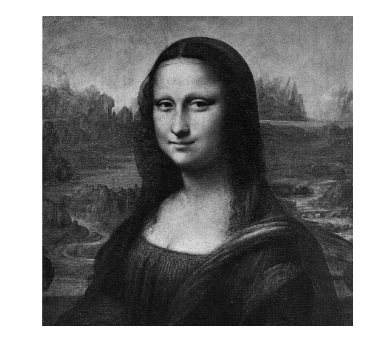

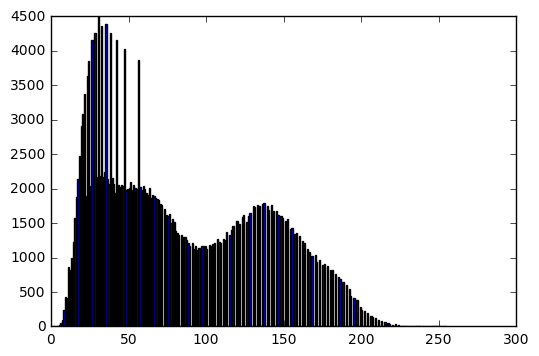

In [71]:
transformed_im = transform(im, which_transform='power', power=2)

bins, hist = get_histogram(transformed_im)

# Display result
plt.figure(0)
plt.imshow(transformed_im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.figure(1)
plt.bar(bins[:-1], hist)

print('Transformed image info:')
print('Data type: ', transformed_im.dtype)
print('Min intensity value: ', transformed_im.min())
print('Max intensity value: ', transformed_im.max())
print('Mean: ', np.mean(transformed_im))
print('Standard deviation: ', np.std(transformed_im))